# Pylops - acoustic wavefield separation

### Author: M.Ravasi

This notebook is inspired by the paper of *J. van der Neut and F. J. Herrmann, Up/Down Wavefield Decomposition by Sparse Inversion, 74th EAGE Conference and Exhibition*, where multi-component seismic data ($p(t,x)$ and $v_z(t,x)$) are inverted by inverting the underlying equations that explain those wavefields as superposition of the up- and downgoing components of the pressure wavefield ($p^-(t,x)$ and $p^+(t,x)$) :

$$ \begin{bmatrix}
            \mathbf{p}  \\
            \mathbf{v_z}  
        \end{bmatrix} =  \frac{1}{2}
\begin{bmatrix}
    1  & 1 \\
    \frac{k_z}{\omega \rho}  & - \frac{k_z}{\omega \rho}  \\
\end{bmatrix}
\begin{bmatrix}
    \mathbf{p^+}  \\
    \mathbf{p^-}  
\end{bmatrix}   = \mathbf{W}  \mathbf{p_{dec}}$$

as in *Wapenaar, K., 1998, Reciprocity properties of one-way propagators: Geophysics, Vol. 63, 1795-1798*, where all wavefields are expressed here in the $(f, k_x)$ domain in 2d (or $(f, k_x, k_y)$ in 3d), $\omega=2\pi f$ is the angular frequency, $k_x$ and $k_y$ are the horizontal wavenumbers, and $k_z=\sqrt{k^2-k_x^2}$ is the vertical wavenumber. Morevoer, $\frac{k_z}{\omega \rho}$ is called obliquity factor.

To start we will consider the analytic solution of the above equation as in practice we record $p$ and $v_z$.

$$ \begin{bmatrix}
            \mathbf{p^+}  \\
            \mathbf{p^-}  
        \end{bmatrix} =  \frac{1}{2}
\begin{bmatrix}
    1  & \frac{\omega \rho}{k_z} \\
    1  & - \frac{\omega \rho}{k_z}  \\
\end{bmatrix}
\begin{bmatrix}
    \mathbf{p}  \\
    \mathbf{v_z}  
\end{bmatrix}$$

The advantage of obtaining $p^-$ and $p^+$ by inversion is that we can stabilize our procedure and obtained improved wavefields in presence of noisy data as shown in *van der Neut and Herrman (2015)*. Moreover as the equations are in the wavenumber domain, having densely, regularly sampled *x* and *y* axes (receivers in IL and XL) direction is a pre-requisite for performing the FFT along those axes (while it is possible to perform FFT with irregularly sampled axis, this is costly, and sparse sampling leads to aliasing which does not allow appyling the obliquity factor to $V_z$).

A possible way to circumvent this condition (when not achieved in acquisition) is to write the problem in the following way:

$$ \mathbf{d} =  \frac{1}{2}
\mathbf{R} \mathbf{F}^H \mathbf{W} \mathbf{F} \mathbf{p_{dec}}  $$

where $\mathbf{F}$ is a 2d or 3d FFT, $\mathbf{R}$ is a restriction (or even better a bilinear interpolation) operator, and the model and data are now in $(t,x)$ domain. The actual wavefield combination via $\mathbf{W}$ is done on regularly sampled wavefields and then sampling in performed in the original time-space domain to bring them to the actual acqisition grid. When solved by inversion this problem allows us to retreive up- and down- decomposed field in an ideal, regualrly and densely sampled geometry. It is expected that to be able to solve this problem a sparsity-promoting condition should be defined for the model to retrieved model such as

$$J = |\mathbf{x_{dec}}|_1 s.t.  \mathbf{d} = \frac{1}{2}
\mathbf{R} \mathbf{F}^H \mathbf{W} \mathbf{F} \mathbf{S}^H \mathbf{x_{dec}}   $$

where $\mathbf{x_{dec}}=\mathbf{S}^H \mathbf{x_{dec}}$ are the wavefields in a sparse domain (ideally curvelets or wave atoms). Note that if f-k can be the sparse domain then the problem becomes even simpler

$$J = |\mathbf{x_{dec}}|_1 s.t.  \mathbf{d} = \frac{1}{2}
\mathbf{R} \mathbf{F}^H \mathbf{W} \mathbf{x_{dec}}   $$

This notebooks is organized as follow:

1. 2D analytical wavefield separation using PyLops chained operators
2. 2D wavefield separation by inversion
3. 2D analytical wavefield separation with irregularly and sparsely sampled x and sparsity promoting inversion (TO BE DONE..)
4. 3D analytical wavefield separation by inversion (TO BE DONE..)
5. 3D analytical wavefield separation with irregularly and sparsely sampled x and y and sparsity promoting inversion (TO BE DONE..)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

Let's import input data from fiel

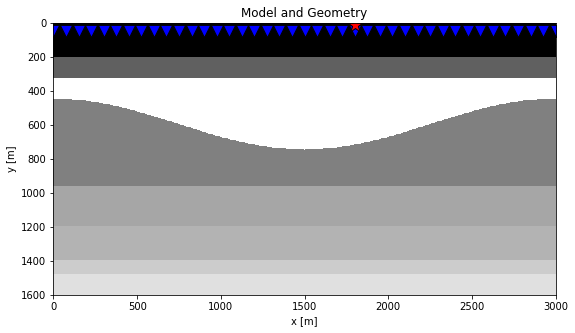

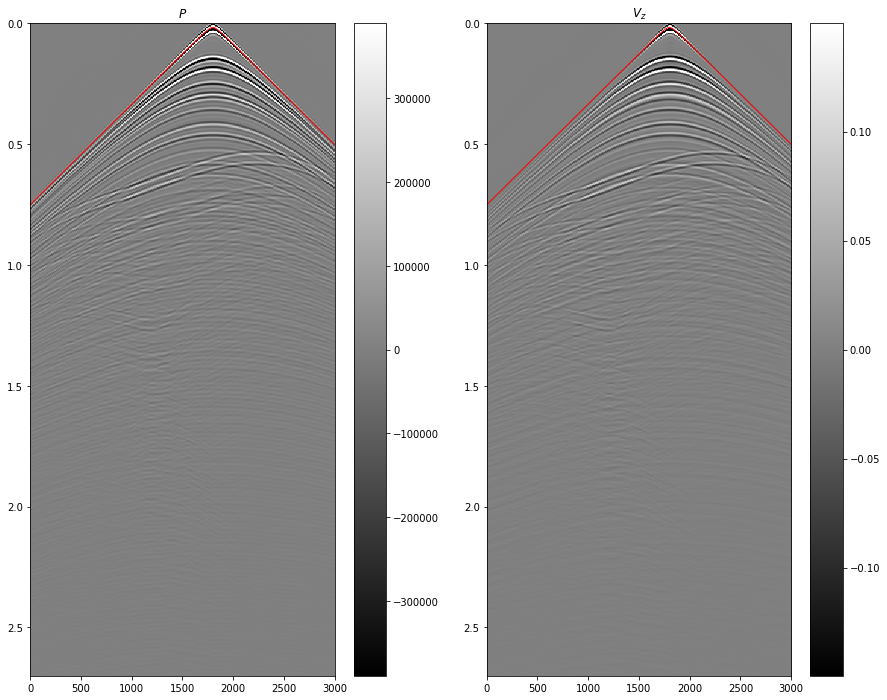

In [2]:
inputfile = '../../pylops/testdata/updown/input.npz'
vel_sep = 2400.0         # velocity at separation level
rho_sep = 1000.0         # density at separation level

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']

# Model
rho = inputdata['rho']

# Axes
t = inputdata['t']
nt, dt = len(t), t[1]-t[0]
x, z = inputdata['x'], inputdata['z']

# Data
p = inputdata['p']
vz = -inputdata['vz']

# Add noise
#p += np.random.normal(0, 1e4, p.shape)
#vz += np.random.normal(0, 2e-2, p.shape)

# First arrival
direct = np.sqrt(np.sum((s[:,np.newaxis]-r)**2, axis=0))/vel_sep

plt.figure(figsize=(9,5))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);
plt.ylim(z[-1], z[0]);

fig, axs = plt.subplots(1, 2, figsize=(15,12))
im=axs[0].imshow(p, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$P$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(vz, cmap='gray', vmin=-0.1*np.abs(vz).max(), vmax=0.1*np.abs(vz).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$V_z$')
axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

Create frequency-wavenumber spectra (using PyLops FFT2D)

In [3]:
nfft=2**11
FFTop = FFT2D(dims=[nt, nr], nffts=[nfft, nfft], sampling=[dt, dr])
dottest(FFTop, nfft*nfft, nt*nr, complexflag=2)

P = FFTop*p.flatten()
VZ = FFTop*vz.flatten()
P = P.reshape(nfft, nfft)
VZ = VZ.reshape(nfft, nfft)

### 1a. 2D Analytical wavefield separation

<Figure size 432x288 with 0 Axes>

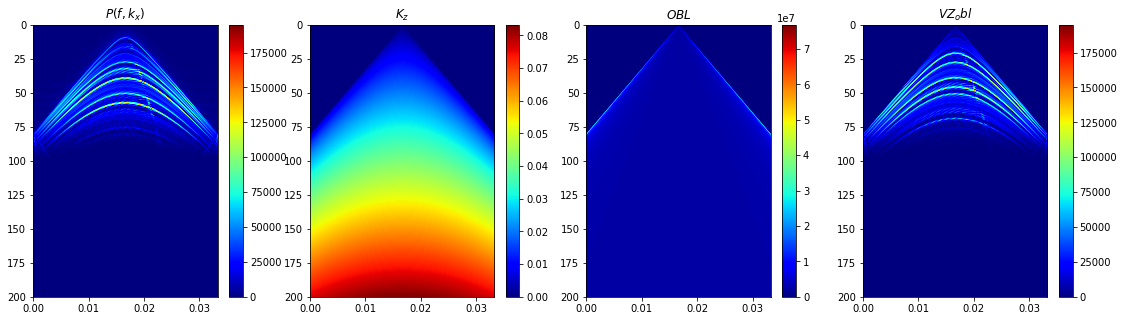

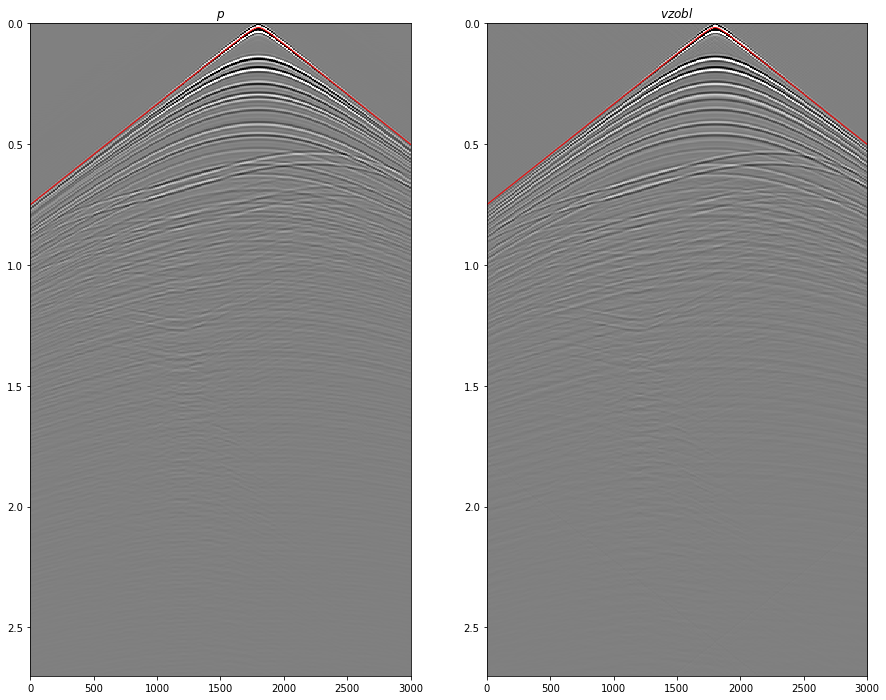

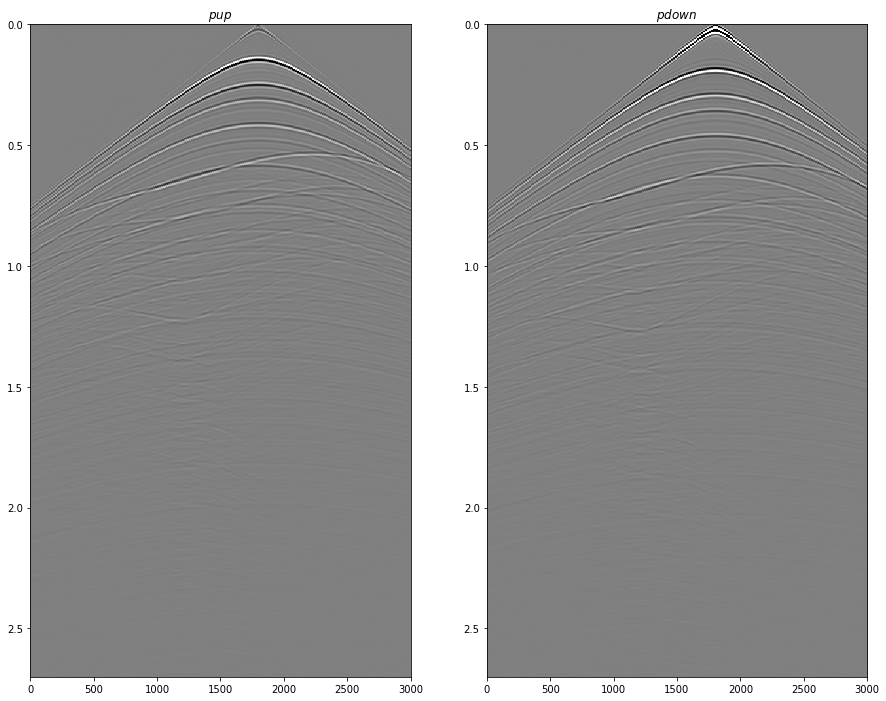

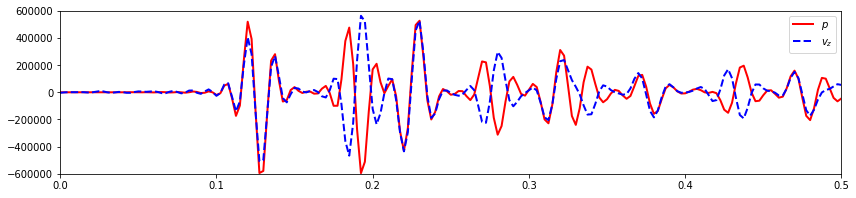

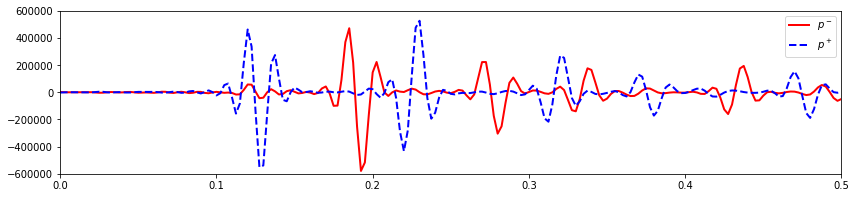

In [4]:
#obliquity factor
[Kx, F] = np.meshgrid(FFTop.f2, FFTop.f1)
k=F/vel_sep
Kz=np.sqrt(k**2-Kx**2)
Kz[np.isnan(Kz)] = 0
plt.figure()

OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0

# cut off
#critical = 0.4
#mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
#OBL = OBL*mask

# taper
#ntaper = 31
#OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=0)
#OBL = filtfilt(np.ones(ntaper)/float(ntaper), 1, OBL, axis=1)

# scaled Vz
VZ_obl = OBL*VZ;
vz_obl = FFTop.H*VZ_obl.flatten()
vz_obl = np.real(vz_obl.reshape(nt, nr))

p = FFTop.H*P.flatten()
p = np.real(p.reshape(nt, nr))

# separation
pup=(p-vz_obl)/2;
pdown=(p+vz_obl)/2;


fig, axs = plt.subplots(1, 4, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(P[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
             extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],),
             vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(Kz[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
             extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],))
axs[1].set_title(r'$K_z$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im=axs[2].imshow(np.fft.fftshift(np.abs(OBL[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
                 extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],))
axs[2].set_title(r'$OBL$')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2])
im=axs[3].imshow(np.fft.fftshift(np.abs(VZ_obl[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
                 extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[3].set_title(r'$VZ_obl$')
axs[3].axis('tight')
plt.colorbar(im, ax=axs[3])

fig, axs = plt.subplots(1, 2, figsize=(15,12))
axs[0].imshow(p, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$vzobl$')
axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(15,12))
axs[0].imshow(pup, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
#axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[:, nr//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[:, nr//2], '--b', lw=2, label=r'$v_z$')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup[:, nr//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown[:, nr//2], '--b', lw=2, label=r'$p^+$')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()

### 1b.  Analytical wavefield separation with PyLops operators

In [5]:
nfft=2**11
FFTop = FFT2D(dims=[nt, nr], nffts=[nfft, nfft], sampling=[dt, dr])

P = FFTop*p.flatten()
VZ = FFTop*vz.flatten()
P = P.reshape(nfft, nfft)
VZ = VZ.reshape(nfft, nfft)

In [6]:
OBLop = Diagonal(OBL.flatten(), dtype='complex128')

Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
    Block([[Identity(nfft*nfft, dtype='complex128'), OBLop],
           [Identity(nfft*nfft, dtype='complex128'), -OBLop]])*\
           BlockDiag([FFTop, FFTop]))

d = np.concatenate((p.flatten(), vz.flatten()))
dud_lop = np.real(Sop*d)

d = d.reshape(2*nt, nr)
dud_lop = dud_lop.reshape(2*nt, nr)

pdown_lop, pup_lop= dud_lop[:nt], dud_lop[nt:]

print(np.linalg.norm(pdown - pdown_lop))
print(np.linalg.norm(pup - pup_lop))

5.067685563946313e-09
3.6598031823824136e-09


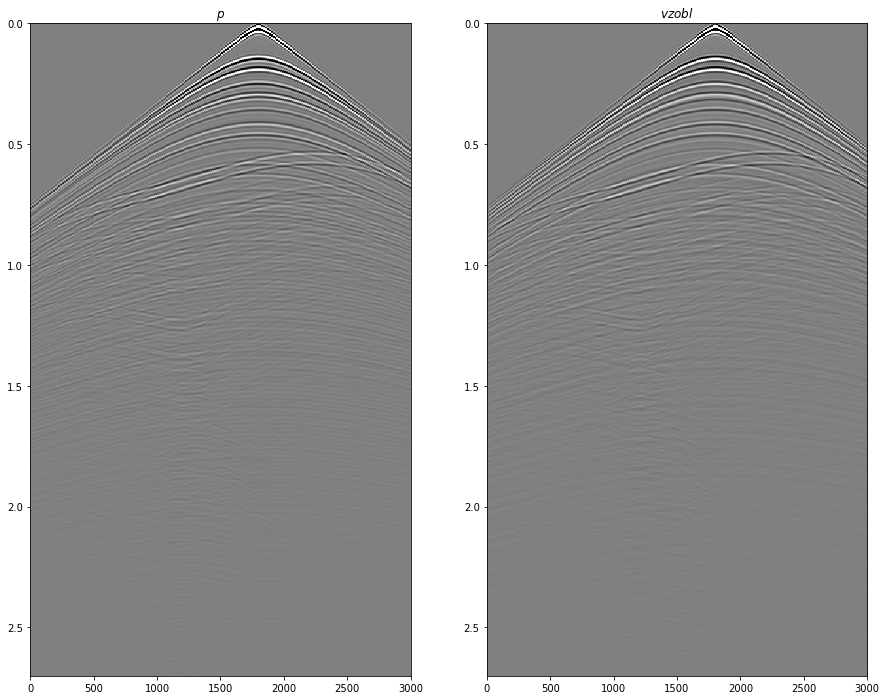

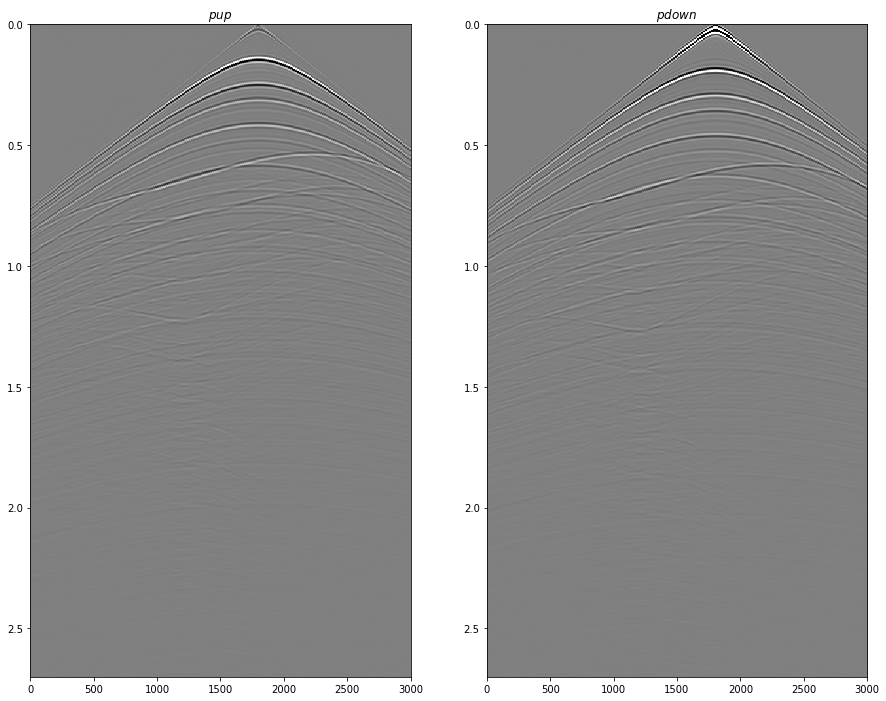

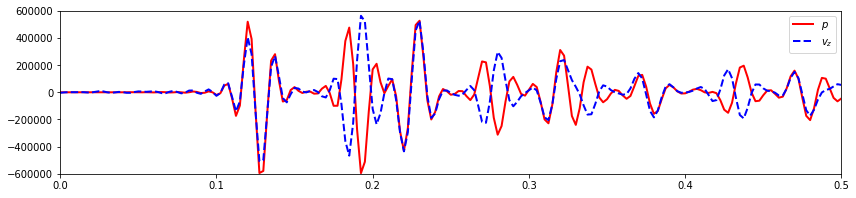

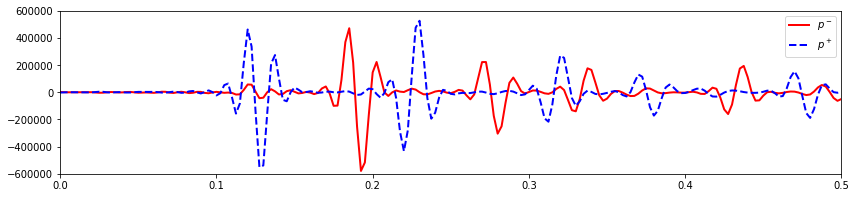

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,12))
axs[0].imshow(p, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
#axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$vzobl$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(15,12))
axs[0].imshow(pup_lop, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
#axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_lop, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[:, nr//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[:, nr//2], '--b', lw=2, label=r'$v_z$')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_lop[:, nr//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_lop[:, nr//2], '--b', lw=2, label=r'$p^+$')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()

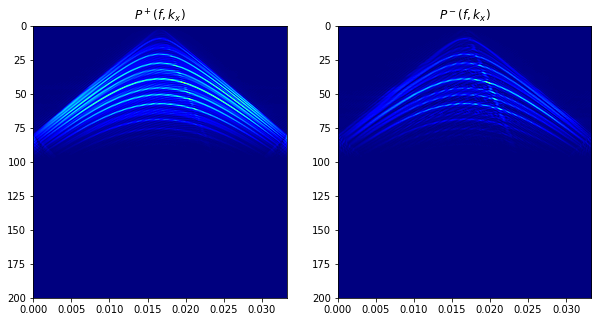

In [8]:
PUP_lop = (FFTop*pup_lop.flatten()).reshape(nfft, nfft)
PDOWN_lop = (FFTop*pdown_lop.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN_lop[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
                 extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP_lop[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
                 extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');

## 2. Wavefield separation by inversion

In [9]:
OBL1=Kz /(rho_sep*np.abs(F))
OBL1[F==0]=0

OBL1op = Diagonal(OBL1.flatten(), dtype='complex128')

S1op = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
    Block([[Identity(nfft*nfft, dtype='complex128'), Identity(nfft*nfft, dtype='complex128')],
           [OBL1op, -OBL1op]])*\
           BlockDiag([FFTop, FFTop]))

d = np.concatenate((p.flatten(), vz.flatten()))
dottest(S1op, 2*nt*nr, 2*nt*nr)

True

5.067685563946313e-09
3.6598031823824136e-09


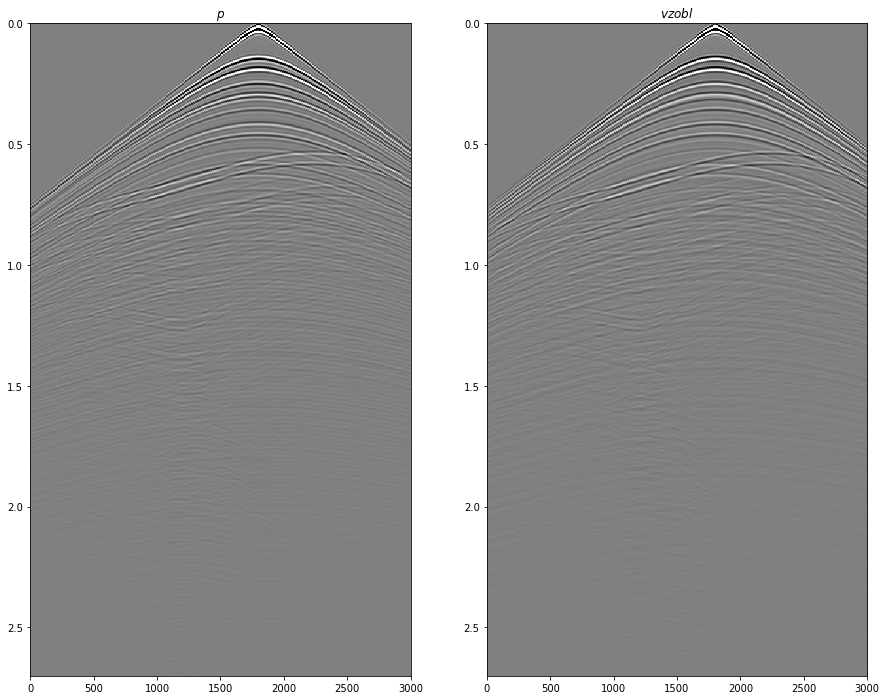

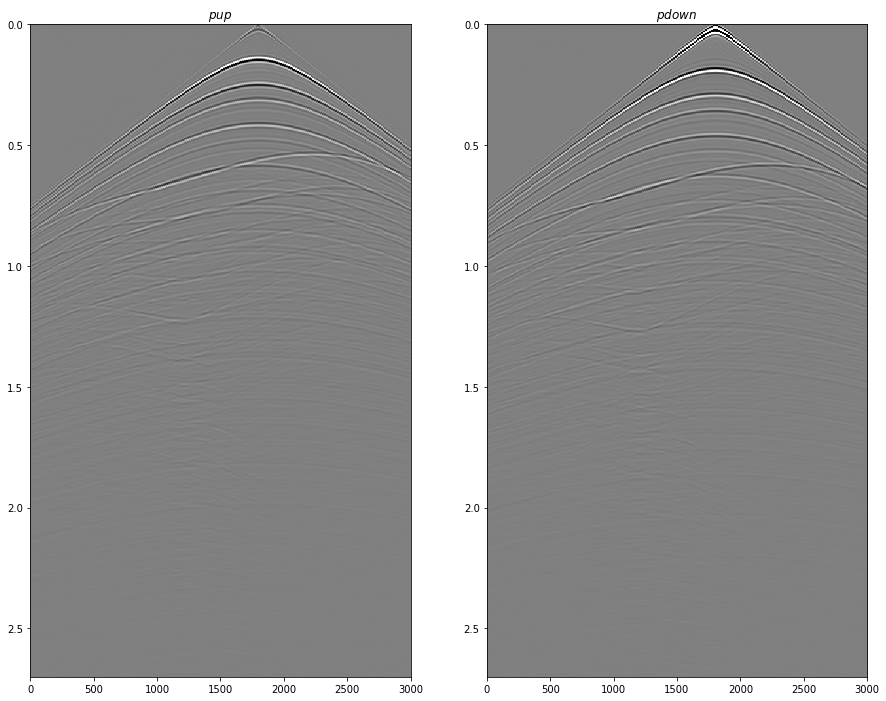

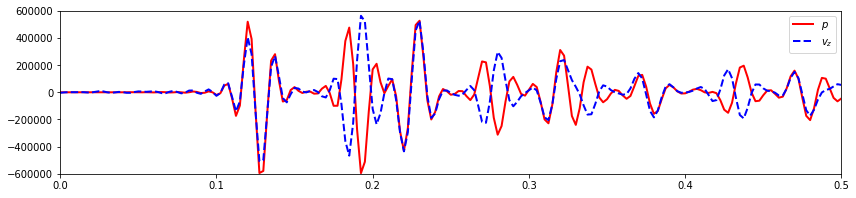

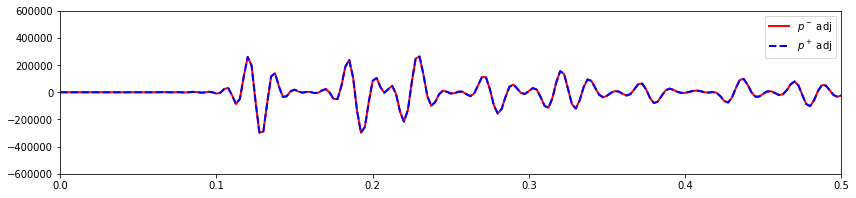

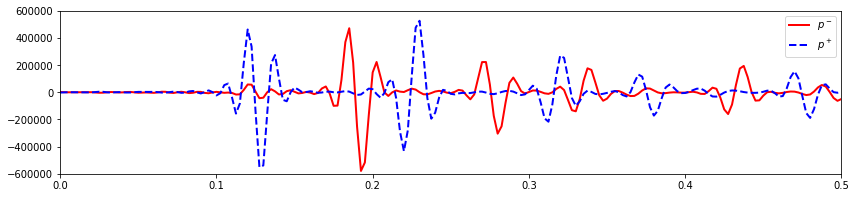

In [10]:
dud_adj = np.real(S1op.H * d)
dud_inv, istop, itn, r1norm, r2norm = lsqr(S1op, d, damp=1e-10, iter_lim=50, show=0)[0:5]
dud_inv = np.real(dud_lop)

d = d.reshape(2*nt, nr)
dud_adj = dud_adj.reshape(2*nt, nr)
dud_inv = dud_inv.reshape(2*nt, nr)

pdown_adj, pup_adj= dud_adj[:nt], dud_adj[nt:]
pdown_inv, pup_inv= dud_inv[:nt], dud_inv[nt:]

print(np.linalg.norm(pdown - pdown_inv))
print(np.linalg.norm(pup - pup_inv))

fig, axs = plt.subplots(1, 2, figsize=(15,12))
axs[0].imshow(p, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
#axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[1].imshow(vz_obl, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$vzobl$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

fig, axs = plt.subplots(1, 2, figsize=(15,12))
axs[0].imshow(pup_inv, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
#axs[0].plot(r[0], direct, 'r', lw=1)
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown_inv, cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
#axs[1].plot(r[0], direct, 'r', lw=1)
axs[1].axis('tight')

plt.figure(figsize=(14, 3))
plt.plot(t, p[:, nr//2], 'r', lw=2, label=r'$p$')
plt.plot(t, vz_obl[:, nr//2], '--b', lw=2, label=r'$v_z$')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_adj[:, nr//2], 'r', lw=2, label=r'$p^-$ adj')
plt.plot(t, pdown_adj[:, nr//2], '--b', lw=2, label=r'$p^+$ adj')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()
plt.figure(figsize=(14, 3))
plt.plot(t, pup_inv[:, nr//2], 'r', lw=2, label=r'$p^-$')
plt.plot(t, pdown_inv[:, nr//2], '--b', lw=2, label=r'$p^+$')
plt.xlim(0,t[200])
plt.ylim(-6e5, 6e5)
plt.legend()

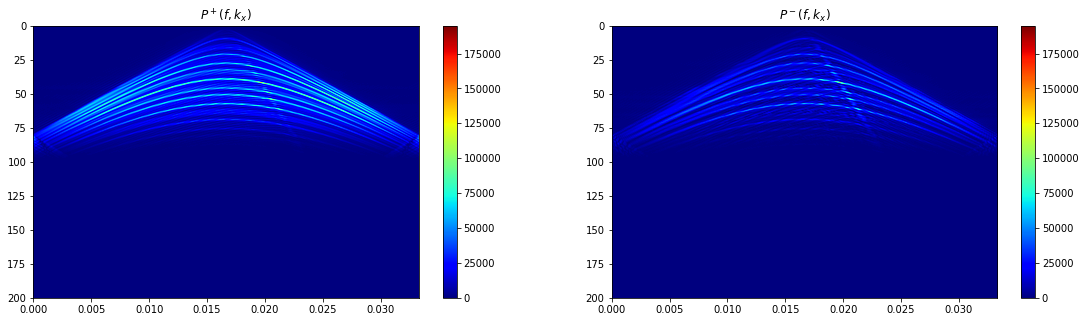

In [11]:
PUP_inv = (FFTop*pup_inv.flatten()).reshape(nfft, nfft)
PDOWN_inv = (FFTop*pdown_inv.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(19,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN_inv[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
                 extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP_inv[:nfft//2-1]),axes=1), cmap='jet', interpolation='sinc',
                 extent = (FFTop.f2[0], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0],),
                 vmin=0, vmax=np.abs(P).max())
axs[0].set_title(r'$P^+(f, k_x)$')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

## 3. Wavefield separation by inversion with sparsity (model in local linear radon domain)